In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-03-18 13:56:46.933249: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-03-18 13:56:46.933290: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
resampler = 'tsc'

## Average density

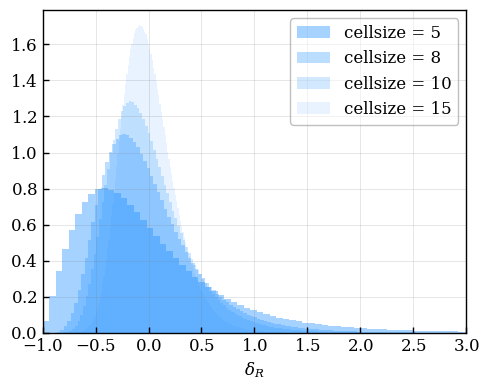

In [44]:
particles_cellsize5_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize5_resampler{}_delta_R.npy'.format(z, resampler))
particles_cellsize8_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize8_resampler{}_delta_R.npy'.format(z, resampler))
particles_cellsize10_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize10_resampler{}_delta_R.npy'.format(z, resampler))
particles_cellsize15_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize15_resampler{}_delta_R.npy'.format(z, resampler))

plt.hist(particles_cellsize5_delta_R, bins=400, density=True, alpha=0.4, color='C0', label=r'cellsize = 5')
plt.hist(particles_cellsize8_delta_R, bins=300, density=True, alpha=0.3, color='C0', label=r'cellsize = 8')
plt.hist(particles_cellsize10_delta_R, bins=300, density=True, alpha=0.2, color='C0', label=r'cellsize = 10')
plt.hist(particles_cellsize15_delta_R, bins=300, density=True, alpha=0.1, color='C0', label=r'cellsize = 15')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

In [51]:
def compute_delta0_sigma_from_moments(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = np.mean(delta_R**2) #moment(delta_R, 2)
    if m3 is None:
        m3 = np.mean(delta_R**3) #moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0_cellsize5, sigma_cellsize5 = compute_delta0_sigma_from_moments(particles_cellsize5_delta_R)
delta0_cellsize8, sigma_cellsize8 = compute_delta0_sigma_from_moments(particles_cellsize8_delta_R)
delta0_cellsize10, sigma_cellsize10 = compute_delta0_sigma_from_moments(particles_cellsize10_delta_R)
delta0_cellsize15, sigma_cellsize15 = compute_delta0_sigma_from_moments(particles_cellsize15_delta_R)

print(delta0_cellsize5, sigma_cellsize5)
print(delta0_cellsize8, sigma_cellsize8)
print(delta0_cellsize10, sigma_cellsize10)
print(delta0_cellsize15, sigma_cellsize15)

1.1201147059493604 0.5894465224422462
1.0003771485536075 0.4339201695608711
0.9711193674625868 0.3661967062628833
0.9524589285079199 0.26318199777631335


In [10]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

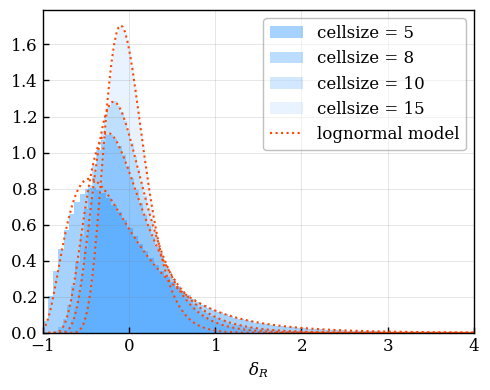

In [52]:
pdf_cellsize5 = plt.hist(particles_cellsize5_delta_R, bins=400, density=True, alpha=0.4, color='C0', label=r'cellsize = 5')
pdf_cellsize8 = plt.hist(particles_cellsize8_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'cellsize = 8')
pdf_cellsize10 = plt.hist(particles_cellsize10_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'cellsize = 10')
pdf_cellsize15 = plt.hist(particles_cellsize15_delta_R, bins=200, density=True, alpha=0.1, color='C0', label=r'cellsize = 15')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize5, delta0_cellsize5), color='C1', ls=':', label=r'lognormal model')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize8, delta0_cellsize8), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize10, delta0_cellsize10), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize15, delta0_cellsize15), color='C1', ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.legend()
plt.show()

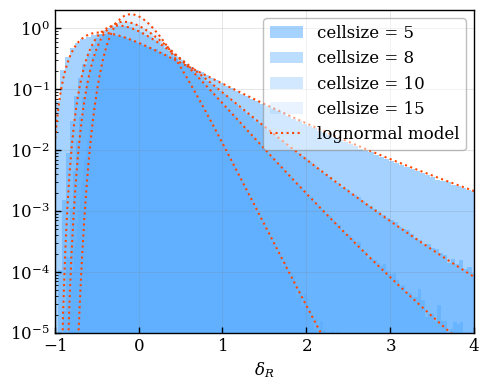

In [54]:
plt.hist(particles_cellsize5_delta_R, bins=400, density=True, alpha=0.4, color='C0', label=r'cellsize = 5')
plt.hist(particles_cellsize8_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'cellsize = 8')
plt.hist(particles_cellsize10_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'cellsize = 10')
plt.hist(particles_cellsize15_delta_R, bins=200, density=True, alpha=0.1, color='C0', label=r'cellsize = 15')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize5, delta0_cellsize5), color='C1', ls=':', label=r'lognormal model')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize8, delta0_cellsize8), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize10, delta0_cellsize10), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize15, delta0_cellsize15), color='C1', ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 2))
plt.legend()
plt.show()

In [55]:
def chisq(delta_R_pdf, sigma, delta0):
    delta = (delta_R_pdf[1][1:]+delta_R_pdf[1][:-1])/2.
    model = friedrich_lognormal_model(delta, sigma, delta0)
    return np.sum((delta_R_pdf[0]-model)**2)

print(chisq(pdf_cellsize5, sigma_cellsize5, delta0_cellsize5))
print(chisq(pdf_cellsize8, sigma_cellsize8, delta0_cellsize8))
print(chisq(pdf_cellsize10, sigma_cellsize10, delta0_cellsize10))
print(chisq(pdf_cellsize15, sigma_cellsize15, delta0_cellsize15))

0.031432301890209395
0.007841901170604071
0.003706099313773737
0.06640597303443907


In [57]:
def compute_bestfit_delta0_sigma(delta_R_pdf, x0):
    def to_min(params, *args):
        pdf = args
        delta0 = params[0]
        sigma = params[1]
        x = pdf[0]
        y = friedrich_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0)
        return np.sum((x-y)**2)
    res = minimize(to_min, x0=x0, args=delta_R_pdf, method='Nelder-Mead')
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    return delta0, sigma

delta0_cellsize5, sigma_cellsize5 = compute_bestfit_delta0_sigma(pdf_cellsize5, x0=np.array([delta0_cellsize5, sigma_cellsize5]))
delta0_cellsize8, sigma_cellsize8 = compute_bestfit_delta0_sigma(pdf_cellsize8, x0=np.array([delta0_cellsize8, sigma_cellsize8]))
delta0_cellsize10, sigma_cellsize10 = compute_bestfit_delta0_sigma(pdf_cellsize10, x0=np.array([delta0_cellsize10, sigma_cellsize10]))
delta0_cellsize15, sigma_cellsize15 = compute_bestfit_delta0_sigma(pdf_cellsize15, x0=np.array([delta0_cellsize15, sigma_cellsize15]))

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.002838205781297278
             x: [ 1.231e+00  5.377e-01]
           nit: 27
          nfev: 53
 final_simplex: (array([[ 1.231e+00,  5.377e-01],
                       [ 1.231e+00,  5.377e-01],
                       [ 1.231e+00,  5.377e-01]]), array([ 2.838e-03,  2.838e-03,  2.838e-03]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0009972751503517401
             x: [ 1.058e+00  4.062e-01]
           nit: 25
          nfev: 48
 final_simplex: (array([[ 1.058e+00,  4.062e-01],
                       [ 1.058e+00,  4.062e-01],
                       [ 1.058e+00,  4.061e-01]]), array([ 9.973e-04,  9.973e-04,  9.973e-04]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0007642697089910165
             x: [ 1.005e+00  3.514e-01]
           nit: 26
   

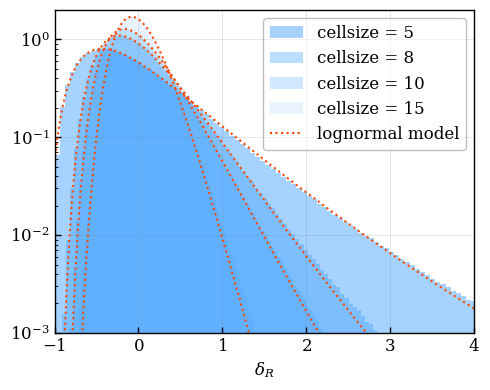

In [62]:
plt.hist(particles_cellsize5_delta_R, bins=400, density=True, alpha=0.4, color='C0', label=r'cellsize = 5')
plt.hist(particles_cellsize8_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'cellsize = 8')
plt.hist(particles_cellsize10_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'cellsize = 10')
plt.hist(particles_cellsize15_delta_R, bins=200, density=True, alpha=0.1, color='C0', label=r'cellsize = 15')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize5, delta0_cellsize5), color='C1', ls=':', label=r'lognormal model')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize8, delta0_cellsize8), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize10, delta0_cellsize10), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_cellsize15, delta0_cellsize15), color='C1', ls=':')
plt.xlabel(r'$\delta_R$')
plt.yscale('log')
plt.ylim((1e-3, 2))
plt.xlim((-1, 4))
plt.legend()
plt.show()